# Challenge: Generative Adversarial Network
### Generative Dog Images

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# torch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.models.vgg import vgg16
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

import argparse
import time
from math import log10
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import xml.etree.ElementTree as ET # for parsing XML
import math
from math import exp

import matplotlib
import matplotlib.pyplot as plt # plotting

import shutil # used for making zip archives of output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generator & Discriminator models

In [2]:
class Generator(nn.Module):
    def __init__(self, nz, channels):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

## Parameters

In [3]:
batch_size = 32
lr = 0.0005
beta1 = 0.5
nz = 128
real_label = 0.9
fake_label = 0.0
epochs = 700

criterion = nn.BCEWithLogitsLoss() 

netG = Generator(nz, 3).to(device)
netD = Discriminator(3).to(device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Data Loader
Loads and preprocesses all images once and stores them in RAM. <br> 
https://www.kaggle.com/speedwagon/ram-dataloader

In [4]:
def bounding_box(image):
    image = '../input/stanford-dogs/annotation/Annotation/' + os.path.splitext(image)[0]
    tree = ET.parse(image)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
    return (xmin,ymin,xmax,ymax)

In [5]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        img_directory_names = os.listdir(img_dir)
        self.img_names = []
        for img_directory_name in img_directory_names:
            list_img_directory_files = os.listdir(img_dir + "/" + img_directory_name)
            for list_img_directory_file in list_img_directory_files:    
                self.img_names.append(img_directory_name + "/" + list_img_directory_file)
                        
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            #bbox=bounding_box(img_name)
            img = Image.open(os.path.join(img_dir, img_name)).convert('RGB')
            #img = img.crop(bbox)
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

## Preprocessing & Data Augmentation
All images are resized to a size of 64x64, higher resolution images are too computationally intensive. <br>
Also applies data augmentation by applying random transformations to the images such as rotations.

In [6]:
transform1 = transforms.Compose([transforms.Resize(64),
                                 transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='../input/stanford-dogs/images/Images',
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

                                           
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

## Images after preprocessing and data augmentation

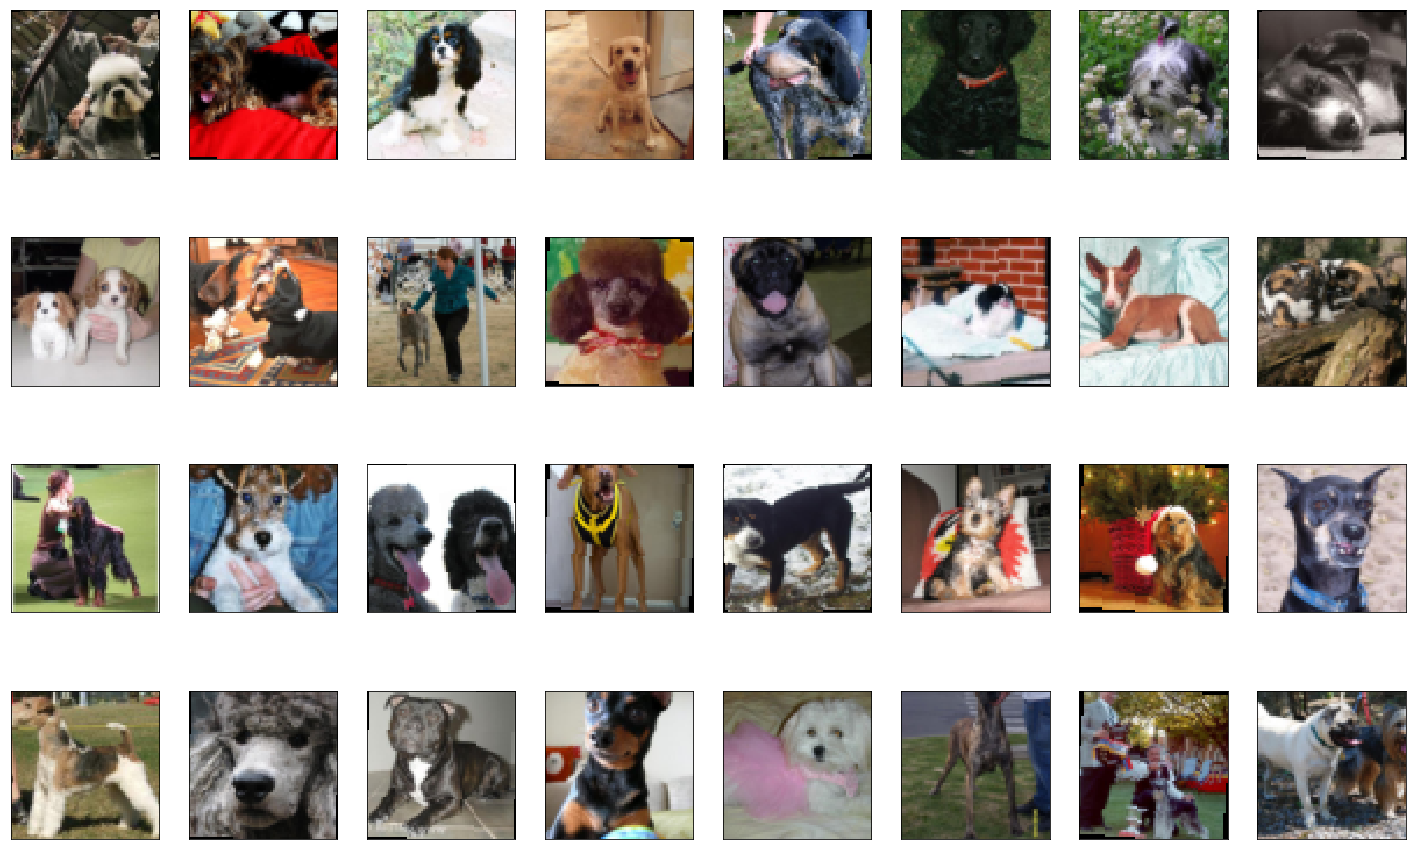

In [7]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

## Training the models

In [8]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.imshow((gen_image+1)/2)
    plt.show()
    
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

[1/700][322/644] Loss_D: 1.3868 Loss_G: 1.0553
[1/700][644/644] Loss_D: 1.5626 Loss_G: 2.0029



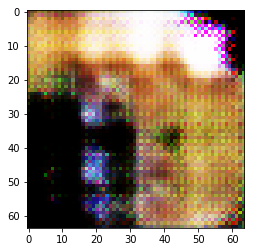

[2/700][322/644] Loss_D: 1.3614 Loss_G: 1.1864
[2/700][644/644] Loss_D: 1.8105 Loss_G: 2.3832



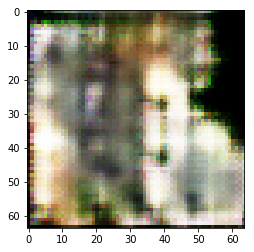

[3/700][322/644] Loss_D: 1.1320 Loss_G: 1.4081
[3/700][644/644] Loss_D: 1.2419 Loss_G: 1.7303



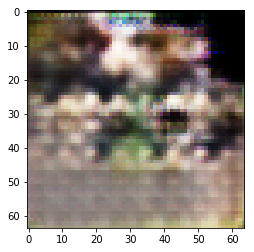

[4/700][322/644] Loss_D: 1.1388 Loss_G: 1.5603
[4/700][644/644] Loss_D: 0.8277 Loss_G: 2.4263



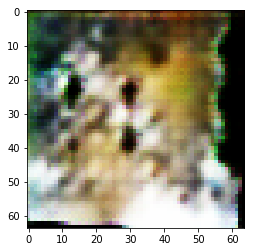

[5/700][322/644] Loss_D: 1.1553 Loss_G: 1.4838
[5/700][644/644] Loss_D: 1.1237 Loss_G: 1.9067



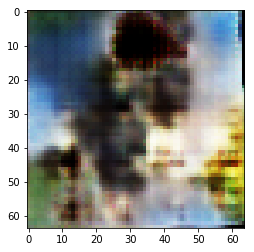

[6/700][322/644] Loss_D: 1.4694 Loss_G: 1.1649
[6/700][644/644] Loss_D: 1.1621 Loss_G: 1.4287



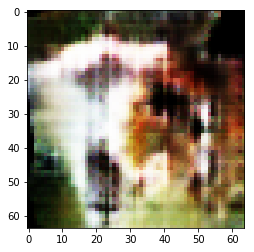

[7/700][322/644] Loss_D: 1.4347 Loss_G: 1.0588
[7/700][644/644] Loss_D: 1.9396 Loss_G: 1.4096



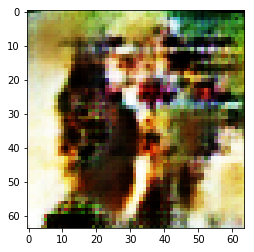

[8/700][322/644] Loss_D: 1.3821 Loss_G: 1.0704
[8/700][644/644] Loss_D: 1.2711 Loss_G: 1.7006



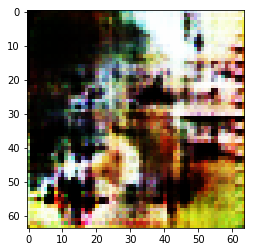

[9/700][322/644] Loss_D: 1.3031 Loss_G: 1.1013
[9/700][644/644] Loss_D: 1.3456 Loss_G: 1.3611



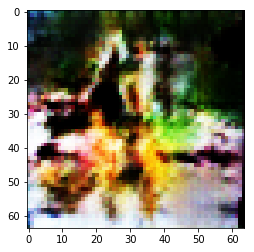

[10/700][322/644] Loss_D: 1.1461 Loss_G: 1.5353
[10/700][644/644] Loss_D: 1.2552 Loss_G: 2.0109



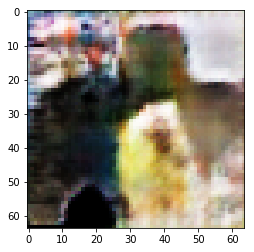

[11/700][322/644] Loss_D: 1.1770 Loss_G: 1.2958
[11/700][644/644] Loss_D: 1.1295 Loss_G: 1.5266



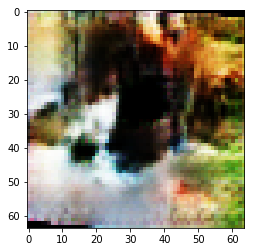

[12/700][322/644] Loss_D: 1.2743 Loss_G: 1.1004
[12/700][644/644] Loss_D: 1.1831 Loss_G: 2.3006



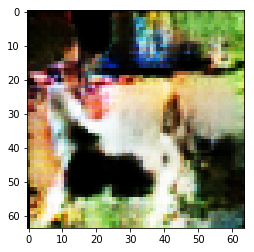

[13/700][322/644] Loss_D: 1.4347 Loss_G: 1.1337
[13/700][644/644] Loss_D: 1.2193 Loss_G: 1.6873



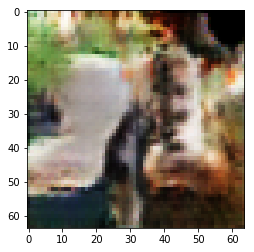

[14/700][322/644] Loss_D: 1.2750 Loss_G: 1.2659
[14/700][644/644] Loss_D: 2.1105 Loss_G: 1.4312



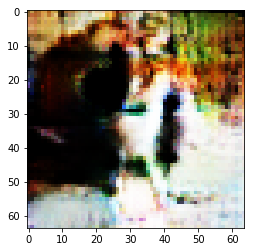

[15/700][322/644] Loss_D: 1.1914 Loss_G: 1.1266
[15/700][644/644] Loss_D: 1.9299 Loss_G: 0.7188



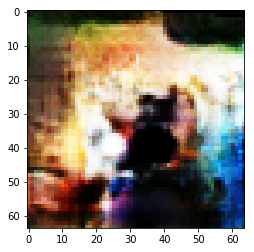

[16/700][322/644] Loss_D: 1.1887 Loss_G: 1.2687
[16/700][644/644] Loss_D: 1.4976 Loss_G: 0.9762



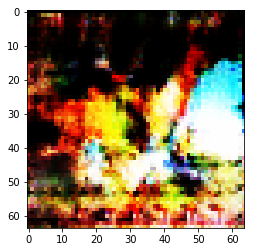

[17/700][322/644] Loss_D: 1.2712 Loss_G: 1.2682
[17/700][644/644] Loss_D: 1.8525 Loss_G: 1.4600



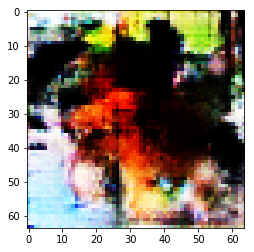

[18/700][322/644] Loss_D: 1.1355 Loss_G: 1.5008
[18/700][644/644] Loss_D: 1.0804 Loss_G: 1.9664



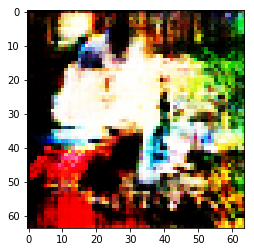

[19/700][322/644] Loss_D: 1.1950 Loss_G: 1.4470
[19/700][644/644] Loss_D: 1.8915 Loss_G: 2.0989



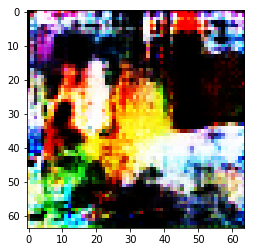

[20/700][322/644] Loss_D: 1.2028 Loss_G: 1.2962
[20/700][644/644] Loss_D: 1.4672 Loss_G: 2.5783



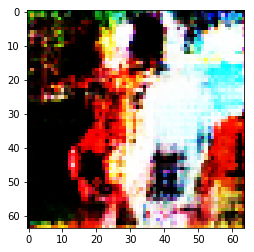

[21/700][322/644] Loss_D: 1.2189 Loss_G: 1.2381
[21/700][644/644] Loss_D: 1.7529 Loss_G: 1.2159



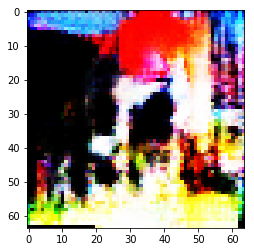

[22/700][322/644] Loss_D: 1.2732 Loss_G: 1.5563
[22/700][644/644] Loss_D: 2.0315 Loss_G: 1.9927



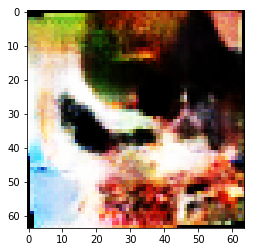

[23/700][322/644] Loss_D: 1.1301 Loss_G: 1.3844
[49/700][644/644] Loss_D: 0.7293 Loss_G: 3.2842



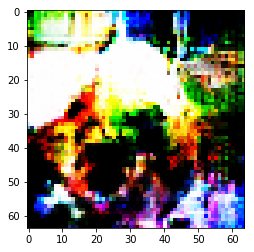

[50/700][322/644] Loss_D: 1.0665 Loss_G: 1.6451
[50/700][644/644] Loss_D: 0.9649 Loss_G: 2.5718



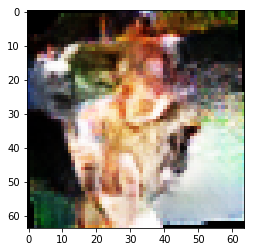

[51/700][322/644] Loss_D: 0.8776 Loss_G: 1.5456
[51/700][644/644] Loss_D: 2.6245 Loss_G: 2.9495



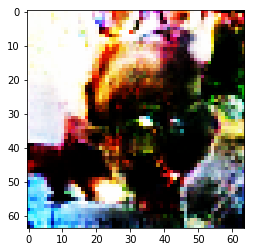

[52/700][322/644] Loss_D: 1.3232 Loss_G: 1.8542
[83/700][322/644] Loss_D: 0.8477 Loss_G: 2.1440
[83/700][644/644] Loss_D: 2.8559 Loss_G: 1.6513



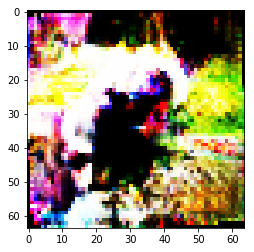

[99/700][644/644] Loss_D: 1.9403 Loss_G: 3.1094



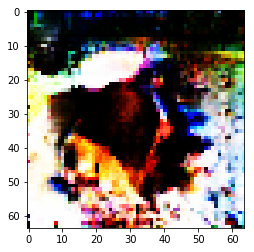

[100/700][322/644] Loss_D: 0.5948 Loss_G: 2.9537
[116/700][322/644] Loss_D: 1.0764 Loss_G: 3.0445
[116/700][644/644] Loss_D: 1.1910 Loss_G: 1.8206



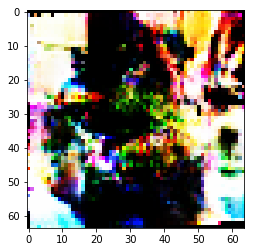

[133/700][322/644] Loss_D: 0.6078 Loss_G: 2.5554
[149/700][644/644] Loss_D: 0.9139 Loss_G: 1.6727



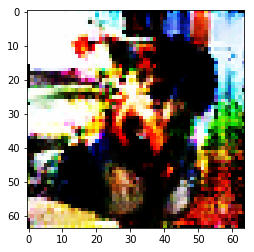

[150/700][322/644] Loss_D: 0.5761 Loss_G: 3.4305
[150/700][644/644] Loss_D: 1.7581 Loss_G: 4.2774



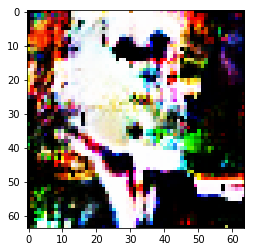

[166/700][322/644] Loss_D: 0.6855 Loss_G: 3.0408
[166/700][644/644] Loss_D: 1.2304 Loss_G: 10.1930



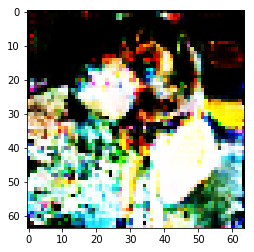

[182/700][644/644] Loss_D: 0.5907 Loss_G: 6.1264



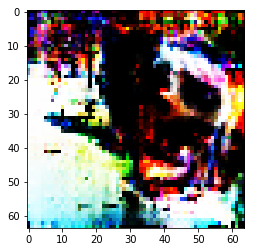

[183/700][322/644] Loss_D: 1.0176 Loss_G: 3.8268
[199/700][322/644] Loss_D: 0.5233 Loss_G: 3.4945
[199/700][644/644] Loss_D: 0.9208 Loss_G: 4.7226



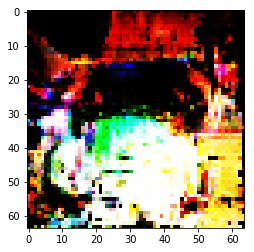

[216/700][322/644] Loss_D: 0.5105 Loss_G: 3.2230
[216/700][644/644] Loss_D: 0.6649 Loss_G: 3.9122



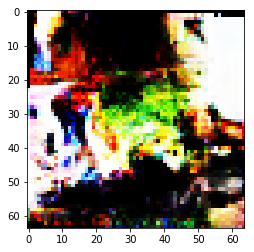

[232/700][644/644] Loss_D: 0.6833 Loss_G: 5.2829



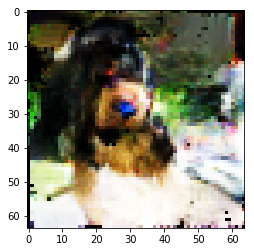

[233/700][322/644] Loss_D: 0.7160 Loss_G: 3.0108
[249/700][322/644] Loss_D: 0.6157 Loss_G: 3.7488
[249/700][644/644] Loss_D: 2.3473 Loss_G: 2.6341



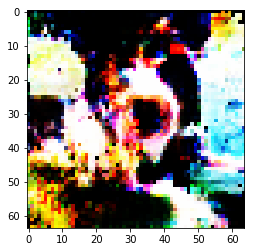

[265/700][644/644] Loss_D: 1.1054 Loss_G: 2.7490



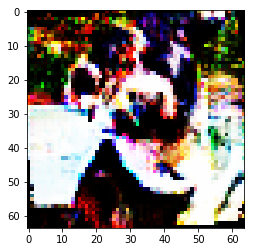

[266/700][322/644] Loss_D: 0.4642 Loss_G: 4.1144
[266/700][644/644] Loss_D: 0.9015 Loss_G: 3.8638



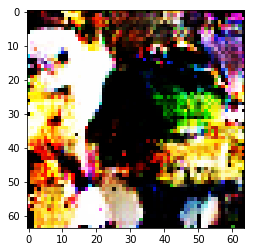

[267/700][322/644] Loss_D: 0.4993 Loss_G: 3.7152
[299/700][322/644] Loss_D: 0.4626 Loss_G: 4.7131
[299/700][644/644] Loss_D: 0.4362 Loss_G: 5.6981



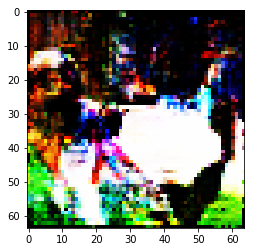

[315/700][644/644] Loss_D: 0.5859 Loss_G: 6.6702



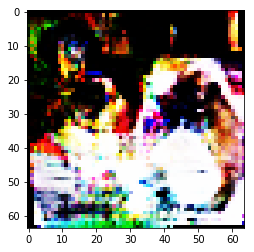

[316/700][322/644] Loss_D: 0.5531 Loss_G: 2.8509
[332/700][322/644] Loss_D: 0.4928 Loss_G: 2.6658
[332/700][644/644] Loss_D: 0.7957 Loss_G: 6.7999



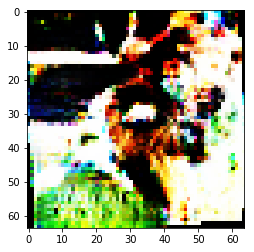

[348/700][644/644] Loss_D: 0.5831 Loss_G: 5.3833



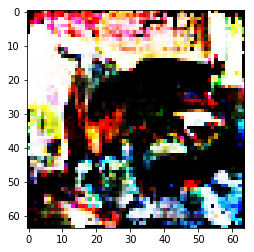

[349/700][322/644] Loss_D: 0.5648 Loss_G: 3.5851
[365/700][322/644] Loss_D: 0.6650 Loss_G: 3.4541
[365/700][644/644] Loss_D: 0.8166 Loss_G: 4.6601



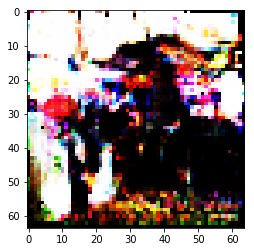

[382/700][322/644] Loss_D: 0.5062 Loss_G: 4.0316
[382/700][644/644] Loss_D: 0.5329 Loss_G: 4.4086



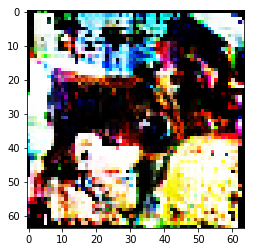

[398/700][644/644] Loss_D: 0.4195 Loss_G: 5.6837



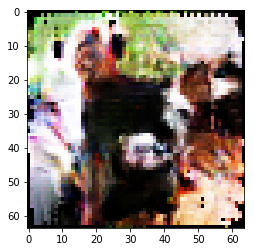

[399/700][322/644] Loss_D: 0.4383 Loss_G: 4.1371
[399/700][644/644] Loss_D: 1.6838 Loss_G: 3.6764



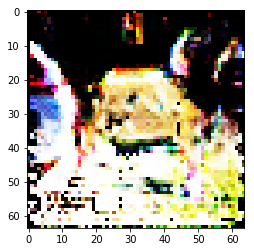

[400/700][322/644] Loss_D: 0.7058 Loss_G: 2.6591
[415/700][322/644] Loss_D: 0.8896 Loss_G: 3.8323
[415/700][644/644] Loss_D: 0.6680 Loss_G: 4.7532



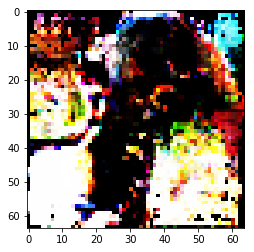

[465/700][322/644] Loss_D: 0.6313 Loss_G: 3.4459
[465/700][644/644] Loss_D: 0.5522 Loss_G: 5.2005



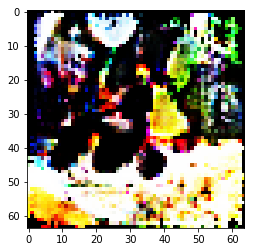

[466/700][322/644] Loss_D: 0.4575 Loss_G: 3.7095
[466/700][644/644] Loss_D: 0.4015 Loss_G: 4.7456

[481/700][644/644] Loss_D: 0.3380 Loss_G: 5.1165



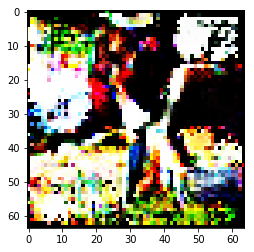

[482/700][322/644] Loss_D: 0.5392 Loss_G: 3.2427
[498/700][322/644] Loss_D: 0.5328 Loss_G: 3.2866
[498/700][644/644] Loss_D: 0.6547 Loss_G: 3.4150



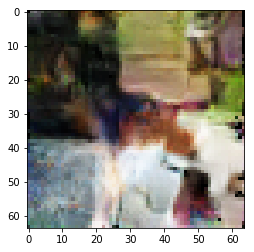

[514/700][644/644] Loss_D: 0.6874 Loss_G: 3.9053



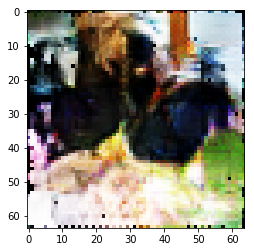

[515/700][322/644] Loss_D: 0.5450 Loss_G: 3.8421
[531/700][644/644] Loss_D: 0.7749 Loss_G: 5.6048



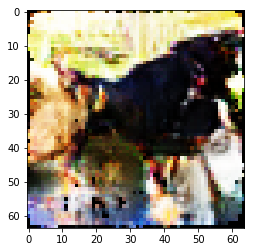

[532/700][322/644] Loss_D: 0.5357 Loss_G: 3.5653
[532/700][644/644] Loss_D: 0.5180 Loss_G: 4.9896



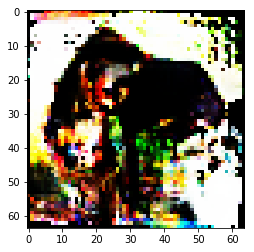

[548/700][322/644] Loss_D: 0.4311 Loss_G: 4.1401
[548/700][644/644] Loss_D: 0.8858 Loss_G: 2.7459



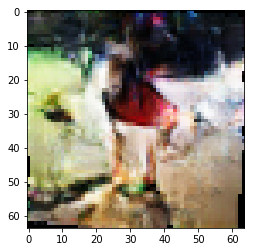

[581/700][322/644] Loss_D: 0.5935 Loss_G: 3.2294
[581/700][644/644] Loss_D: 0.9463 Loss_G: 2.4129



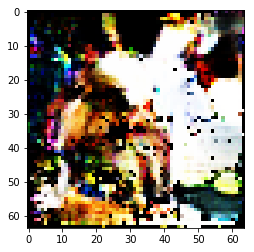

[582/700][322/644] Loss_D: 0.4242 Loss_G: 4.1634
[582/700][644/644] Loss_D: 0.6109 Loss_G: 5.4804



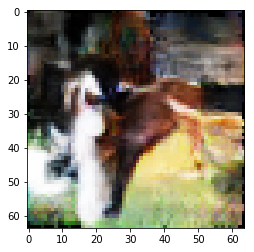

[614/700][322/644] Loss_D: 0.4379 Loss_G: 3.4574
[614/700][644/644] Loss_D: 0.5655 Loss_G: 2.9867



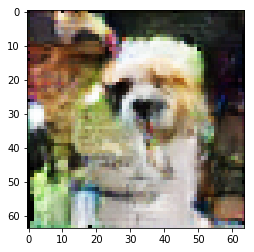

[631/700][322/644] Loss_D: 0.5114 Loss_G: 4.2075
[647/700][644/644] Loss_D: 0.6611 Loss_G: 3.1446



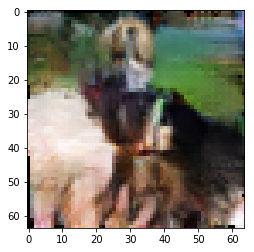

[648/700][322/644] Loss_D: 0.4262 Loss_G: 3.9166
[648/700][644/644] Loss_D: 0.5191 Loss_G: 7.3409



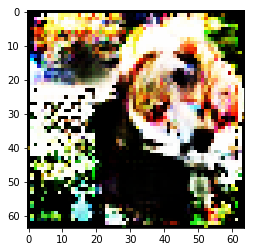

[649/700][322/644] Loss_D: 0.4497 Loss_G: 3.4278
[649/700][644/644] Loss_D: 0.6753 Loss_G: 4.3499



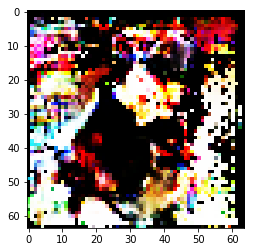

[680/700][644/644] Loss_D: 1.5028 Loss_G: 2.5927



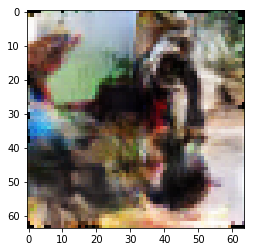

[681/700][322/644] Loss_D: 0.4777 Loss_G: 3.9022
[697/700][322/644] Loss_D: 0.8087 Loss_G: 2.1921
[697/700][644/644] Loss_D: 0.5552 Loss_G: 4.1850



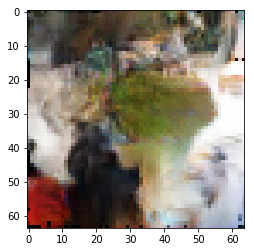

In [9]:
G_losses = []
D_losses = []
G_Mean_loss = []
D_Mean_loss = []

for epoch in range(epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        target = torch.full((batch_size, 1), fake_label, device=device)
        outputF = netD(fake.detach())
        #errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
        #        torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD = criterion(outputR, labels) + criterion(outputF, target)
        errD.backward(retain_graph=True)
        optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        outputF = netD(fake)   
        #errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
        #        torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG = criterion(outputF, labels) 
        errG.backward()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))

    show_generated_img()
    
    G_Mean_loss.append(mean(G_losses))
    D_Mean_loss.append(mean(D_losses))
        
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

## Plotting Generator & Discriminator Loss and Mean Loss

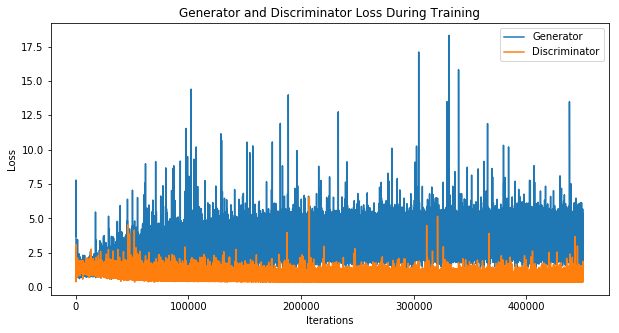

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

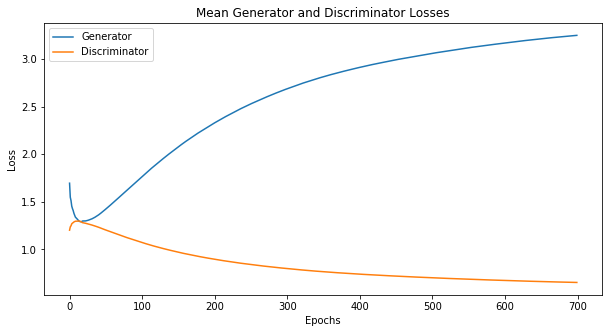

In [11]:
plt.figure(figsize=(10,5))
plt.title("Mean Generator and Discriminator Losses")
plt.plot(G_Mean_loss,label="Generator")
plt.plot(D_Mean_loss,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Generated output images

In [12]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

'/kaggle/working/images.zip'

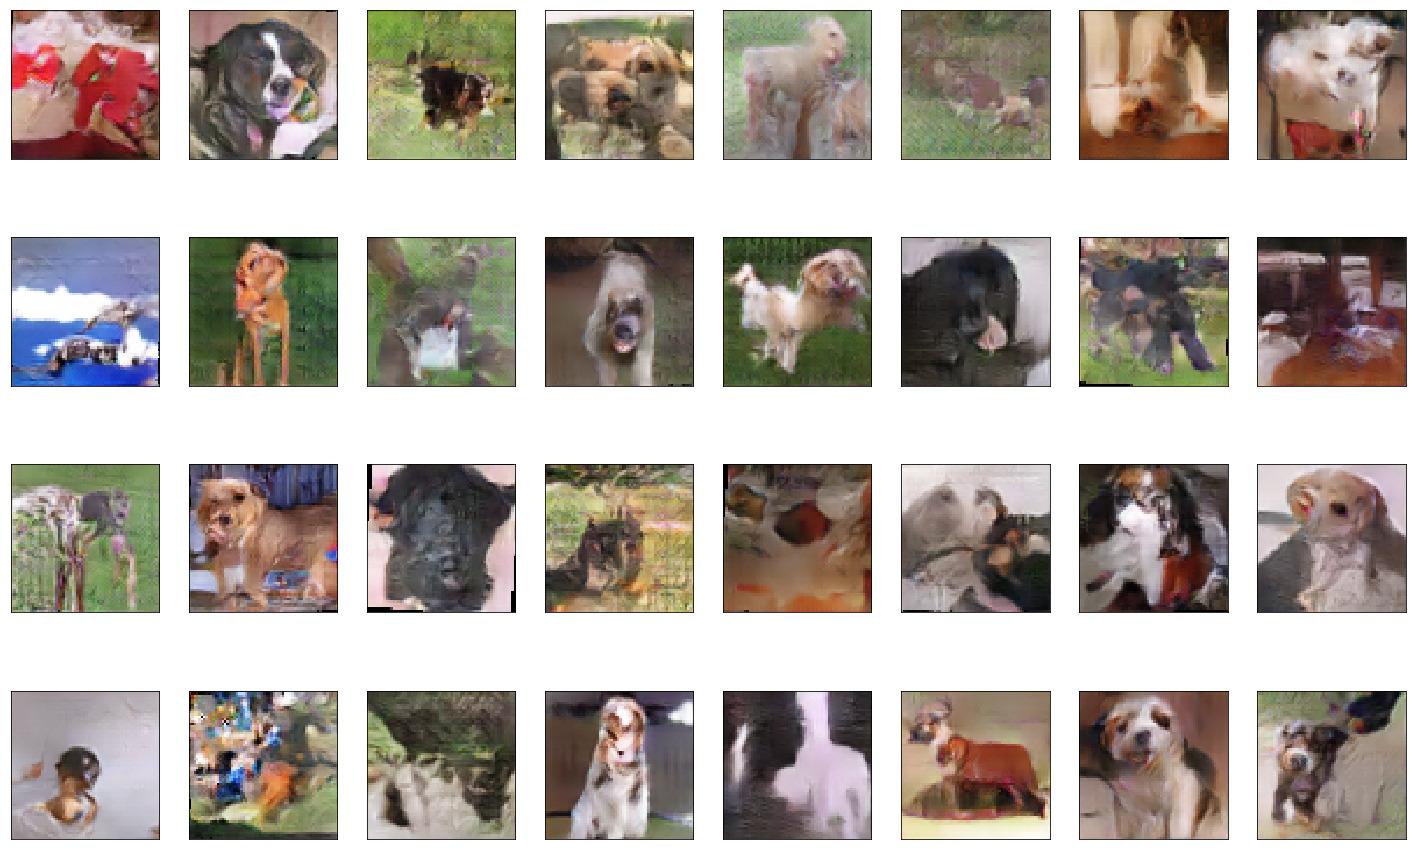

In [13]:
if not os.path.exists('../gen_images'):
        os.mkdir('../gen_images')

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)
    #matplotlib.image.imsave('../gen_images/' + str(ii) + '_gen_img.png', img)
    matplotlib.image.imsave(str(ii) + '_gen_img.png', img)
    
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_imgs = (netG(gen_z) + 1)/2
    images = gen_imgs.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_imgs.size(0)):
        save_image(gen_imgs[i_image, :, :, :], os.path.join('../gen_images', f'image_{i_batch+i_image:05d}.png'))
    
shutil.make_archive('images', 'zip', '../gen_images')

## FID Score Calculation

In [14]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from scipy import linalg
from pathlib import Path
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.GFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
#     layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
                shape2 = []
                for s in shape:
                    if s == None:
                        shape2.append(0)
                    else:
                        shape2.append(s)
                new_shape = []
                for j, s in enumerate(shape2):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=im_batch_size, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=im_batch_size, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png, is_train):
    breed_names = os.listdir(path)
    files = []
    if is_train:
        for breed_name in breed_names:
            path2 = Path(os.path.join(path, breed_name))
            image_names = os.listdir(path2)
            for image_name in image_names:
                if image_name != "n02105855_2933.jpg":
                    files.append(Path(os.path.join(path2, image_name)))
    else:
        path = Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True, is_train = False)
        if feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False, is_train = True)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance

In [15]:
user_images_unzipped_path = '../gen_images/'
images_path = [user_images_unzipped_path,'../input/stanford-dogs/images/Images']

public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

fid_epsilon = 10e-15

fid_value_public, distance_public = calculate_kid_given_paths(images_path, 'Inception', public_path)
distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ", fid_value_public /(distance_public + fid_epsilon))

100%|██████████| 412/412 [01:02<00:00,  6.61it/s]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.23860812540620568
FID_public:  92.9780702436326 distance_public:  1 multiplied_public:  92.97807024363168
